**GETTING THE DATASETS NEEDED**

**Import Libraries**

In [ ]:
import pandas as pd
from tqdm import tqdm
import time
import requests
from bs4 import BeautifulSoup

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Saved Datasets**

Import skinsort Dataset

In [ ]:
file_path = "/content/drive/MyDrive/Dermask AI/19,000+ Skincare Products Dataset.csv"
skinsort_df = pd.read_csv(file_path)

print(skinsort_df.shape)
skinsort_df.head(5)


(19050, 6)


,brand,name,type,country,ingridients,afterUse
0,The Ordinary,Glycolic Acid 7% Toning Solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ..."
1,La Roche-Posay,Toleriane Hydrating Gentle Face Cleanser,Face Cleanser,France,"Water,Glycerin,Pentaerythrityl Tetraethylhexan...","Good For Oily Skin,Redness Reducing,Reduces Ir..."
2,The Ordinary,Niacinamide 10% + Zinc 1%,Facial Treatment,Canada,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight..."
3,Youth To The People,Superfood Antioxidant Cleanser,Face Cleanser,United States,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu..."
4,COSRX,Low pH Good Morning Gel Cleanser,Face Cleanser,South Korea,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ..."


Import Sephora Dataset

In [ ]:
file_path = "/content/drive/MyDrive/Dermask AI/Sephora Skincare Ingredients Dataset.csv"
sephora_df = pd.read_csv(file_path)

print(sephora_df.shape)
sephora_df.head(5)

(1472, 11)


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


Handling NaN to prevent errors

In [ ]:
# Display unique values in the 'type' column of skinsort_df
unique_types = skinsort_df['type'].dropna().unique()

# Print them out, one per line
for t in unique_types:
    print(t)

Toner
Face Cleanser
Facial Treatment
Serum
General Moisturizer
Sunscreen
Exfoliator
Face Makeup
Bath & Body
Makeup Remover
Day Moisturizer
Other Haircare
Shampoo
Fragrance
Hand Care
Conditioner
Lip Moisturizer
Eye Moisturizer
Sheet Mask
Eye Makeup
Tanning
Wet Mask
Emulsion
Overnight Mask
Makeup Applicator
Night Moisturizer
Lip Makeup
Oil
Essence
Cheek Makeup
Nail Care
Lip Mask
Eye Mask
Other
Tool
False Eyelash


In [ ]:
# Define list of product types to keep
keep_types = [
    "Toner", "Face Cleanser", "Facial Treatment", "Serum", "General Moisturizer",
    "Sunscreen", "Exfoliator", "Day Moisturizer", "Night Moisturizer", "Eye Moisturizer",
    "Sheet Mask", "Wet Mask", "Overnight Mask", "Oil", "Essence", "Emulsion",
]

# Filter the DataFrame to keep only relevant facial skincare product types
skinsort_facial_df = skinsort_df[skinsort_df['type'].isin(keep_types)].copy()

# Optional: check how many rows were kept
print(f"Filtered dataset size: {skinsort_facial_df.shape[0]} rows")


Filtered dataset size: 13323 rows


In [ ]:
skinsort_facial_df.shape

(13323, 6)

In [ ]:
skinsort_facial_df.head(2)

,brand,name,type,country,ingridients,afterUse
0,The Ordinary,Glycolic Acid 7% Toning Solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ..."
1,La Roche-Posay,Toleriane Hydrating Gentle Face Cleanser,Face Cleanser,France,"Water,Glycerin,Pentaerythrityl Tetraethylhexan...","Good For Oily Skin,Redness Reducing,Reduces Ir..."


Conert product-level dataset to ingredient level dataset

In [ ]:
# For skinsort_df
skinsort_exploded = skinsort_facial_df.copy()
skinsort_exploded['ingredient'] = skinsort_exploded['ingridients'].str.split(',')
skinsort_exploded = skinsort_exploded.explode('ingredient')
skinsort_exploded['ingredient'] = skinsort_exploded['ingredient'].str.strip()
skinsort_exploded.shape

(372813, 7)

In [ ]:
# For skinsort_df
sephora_exploded = sephora_df.copy()
sephora_exploded['ingredient'] = sephora_exploded['ingredients'].str.split(',')
sephora_exploded = sephora_exploded.explode('ingredient')
sephora_exploded['ingredient'] = sephora_exploded['ingredient'].str.strip()
sephora_exploded.shape

(45671, 12)

In [ ]:
def predict_sodium_comedogenicity(name):
    name = str(name).lower().strip()

    sodium_comedo_map = {
        'pca': 0,
        'sodium pca': 0,
        'zinc pca': 0,
        'sodium lactate': 0,
        'sodium hyaluronate': 0,
        'sodium ascorbyl phosphate': 0,
        'sodium lauryl sulfate': 5,      # highly comedogenic and irritating
        'sodium cocoyl isethionate': 2,  # mild surfactant but can clog some pores
        'sodium chloride': 3,            # salt can be moderately comedogenic, esp. under occlusion
        'sodium benzoate': 0,
        'sodium hydroxide': 0,           # not comedogenic, but can be irritating
        'sodium salicylate': 1,          # mild exfoliant, low comedogenicity
    }

    for key, score in sodium_comedo_map.items():
        if key in name:
            return score

    if name.startswith('sodium '):
        return 1  # Fallback: assume very low risk for unknown sodium derivatives

    return None


In [ ]:
def predict_comedogenicity(name):
    name = str(name).lower().strip()

    sodium_score = predict_sodium_comedogenicity(name)
    if sodium_score is not None:
        return sodium_score
    # High comedogenic ingredients (4-5)
    if any(high in name for high in [
        'coconut oil', 'isopropyl myristate', 'isopropyl palmitate',
        'wheat germ oil', 'lauric acid', 'myristic acid', 'oleic acid'
    ]):
        return 5
    if any(x in name for x in ['butter', 'lanolin']):
        return 4
    # Moderately comedogenic ingredients (2-3)
    if any(med in name for med in [
        'palm oil', 'shea butter', 'mango butter', 'olive oil',
        'cocoa butter', 'grapeseed oil', 'castor oil', 'avocado oil',
        'stearic acid', 'palmitic acid', 'linoleic acid', 'lauryl lactate'
    ]):
        return 3
    if 'oil' in name:
        return 3  # general oil fallback
    if any(med in name for med in ['ethylhexyl', 'capric', 'caprylic', 'oleyl']):
        return 2
    if name.endswith('ate') or 'ester' in name:
        return 2
    if 'alcohol' in name:
        if any(safe in name for safe in ['cetyl', 'stearyl', 'cetearyl', 'behenyl']):
            return 0
        return 2
    if name.endswith('ol'):
        if any(polyol in name for polyol in ['glycerol', 'sorbitol', 'pentylene glycol', 'butylene glycol', 'caprylyl gycol', 'xylitol']):
            return 0
        return 1
    if 'rice' in name or 'tumeric' in name:
        return 1
    if name.endswith('acid'):
        if any(fat in name for fat in ['oleic', 'stearic', 'palmitic', 'lauric', 'myristic']):
            return 3
        return 1
    if 'bha' in name or 'aha' in name:
        return 1
    if name.endswith('gum'):
        return 2
    if name.endswith('powder'):
        return 1
    if name.endswith('root') or name.endswith('leaf'):
        return 1
    if 'dimethicone' in name or 'cyclopentasiloxane' in name or 'silicone' in name:
        return 0  # non-comedogenic silicone-based emollients
    if any(x in name for x in ['glycerin', 'glycerine', 'sorbitol', 'xylitol', 'mannitol', 'propanediol']):
        return 0
    if 'extract' in name or 'enzyme' in name or 'ferment' in name:
        return 1  # mostly plant-based, low risk
    if 'water' in name or 'aqua' in name or 'urea' in name or 'juice' in name:
        return 0
    if name.endswith(('ose', 'ine', 'ane', 'ide', 'one')):
        return 0  # most are safe excipients or fillers
    return -1  # unknown


In [ ]:
def predict_occlusivity(name):
    name = str(name).lower().strip()

    # 🚫 High Occlusivity – heavy film-formers, seal moisture
    if any(high in name for high in [
        'petrolatum', 'mineral oil', 'dimethicone', 'cyclopentasiloxane',
        'lanolin', 'beeswax', 'ozokerite', 'candelilla wax', 'paraffin', 'microcrystalline wax'
    ]):
        return 'High'
    if 'butter' in name:  # shea, cocoa, mango, etc.
        return 'High'
    # 🟠 Medium Occlusivity – emollients or plant oils
    if any(medium in name for medium in [
        'olive oil', 'jojoba oil', 'squalane', 'caprylic', 'capric',
        'avocado oil', 'castor oil', 'grapeseed oil'
    ]):
        return 'Medium'
    if 'oil' in name:
        return 'Medium'
    if name.endswith('ate') or 'ester' in name:
        return 'Medium'
    if name.endswith('ane'):  # e.g. squalane
        return 'Medium'
    # 🟡 Low Occlusivity – some fatty alcohols and sugars
    if any(low in name for low in [
        'cetyl', 'stearyl', 'cetearyl', 'lauryl', 'glyceryl', 'palmitate'
    ]):
        return 'Low'
    if 'alcohol' in name:
        if any(safe in name for safe in ['cetyl', 'stearyl', 'cetearyl']):
            return 'Low'
        return 'None'  # drying alcohols
    if 'acid' in name:
        return 'Low'
    if name.endswith(('ol', 'ine', 'ide', 'one')):
        return 'Low'
    if 'rice' in name or 'tumeric' in name:
        return 'Low'
    if any(none in name for none in [
        'glycerin', 'hyaluronate', 'sodium pca', 'urea', 'sorbitol',
        'panthenol', 'water', 'aqua', 'aloe', 'juice'
    ]):
        return 'None'
    if 'extract' in name or 'enzyme' in name or 'ferment' in name:
        return 'None'
    if name.endswith('ose'):  # sugars like glucose, fructose
        return 'None'
    if name.endswith('gum'):
        return 'Medium'
    if name.endswith('powder'):
        return 'Low'
    if name.endswith('root') or name.endswith('leaf'):
        return 'None'
    return 'None'


sodium-based compounds are very common in skincare formulations (e.g. Sodium PCA, Sodium Lactate, Sodium Hyaluronate, Sodium Hydroxide, Sodium Ascorbyl Phosphate, etc.), and a dedicated rule or function to handle them smartly would improve accuracy, reduce duplication, and make the logic more maintainable.

In [ ]:
def predict_sodium_derivative_type(name):
    name = str(name).lower().strip()

    if not name.startswith('sodium '):
        return None
    second_part = name.replace('sodium ', '').strip()
    if 'lactate' in second_part:
        return 'Ester/Salt'
    elif 'ascorbyl' in second_part:
        return 'Antioxidant'
    elif 'hyaluronate' in second_part:
        return 'Sugar'
    elif 'hydroxide' in second_part:
        return 'Base'
    elif 'cocoyl' in second_part or 'lauryl' in second_part:
        return 'Surfactant'
    elif 'benzoate' in second_part or 'sorbate' in second_part:
        return 'Preservative'
    else:
        return 'Salt'


In [ ]:
def predict_chemical_type(name):
    name = str(name).lower().strip()

    # Smart sodium derivative handler
    sodium_type = predict_sodium_derivative_type(name)
    if sodium_type:
        return sodium_type

    # Oils
    if 'oil' in name and not 'alcohol' in name:
        return 'Oil'

    # Acids (but exclude hyaluronic, amino, and fatty acid derivatives)
    if 'acid' in name and not any(x in name for x in ['hyaluronic', 'amino', 'glutamic', 'aspartic']):
        return 'Acid'
    if 'bha' in name or 'aha' in name:
        return 'Acid'

    # Alcohols and polyols
    if any(x in name for x in ['glycerin', 'glycerine', 'sorbitol', 'xylitol', 'mannitol', 'butylene glycol', 'caprylyl gycol', 'propanediol', 'pentylene glycol']):
        return 'Alcohol'
    if 'alcohol' in name or name.endswith('ol'):
        return 'Alcohol'

    # Esters and salts (neutral or buffering agents)
    if name.endswith('ate') or 'lactate' in name or 'pca' in name or 'urea' in name:
        return 'Ester/Salt'

    # Amino acids or derivatives
    if name.endswith('ine') or name in ['glycine', 'serine', 'valine', 'proline', 'arginine', 'histidine', 'threonine', 'alanine']:
        return 'Amino'

    # Peptides
    if 'peptide' in name:
        return 'Peptide'

    # Sugars
    if name.endswith('ose') or name in ['glucose', 'fructose', 'sucrose', 'trehalose']:
        return 'Sugar'

    # Extracts and plant-derived water
    if 'extract' in name:
        return 'Extract'
    if 'leaf water' in name or 'flower water' in name or 'juice' in name:
        return 'Extract'
    if 'rice' in name or 'tumeric' in name:
        return 'Extract'
    if name.endswith('root') or name.endswith('leaf') or name.endswith('powder'):
        return 'Extract'

    # Water
    if 'water' in name or 'aqua' in name:
        return 'Water'

    # Enzymes and ferments
    if 'enzyme' in name or 'ferment' in name:
        return 'Enzyme'

    # Proteins
    if 'protein' in name:
        return 'Protein'

    # Butters
    if 'butter' in name:
        return 'Butter'

    # Ketones
    if name.endswith('one') and not 'hyaluronic' in name:
        return 'Ketone'

    # Hydrocarbons
    if name.endswith('ane') and 'hexane' not in name:
        return 'Hydrocarbon'

    # Polymers and gels
    if 'gum' in name or 'polymer' in name or 'gel' in name:
        return 'Polymer/Gel'
    if name.endswith('gum'):
        return 'Polymer'

    # General compounds or synthetic blends
    if name.endswith('ide') or 'chloride' in name or 'oxide' in name:
        return 'Compound'

    return 'Other'


In [ ]:
def predict_sodium_function_type(name):
    name = str(name).lower().strip()

    sodium_map = {
        'sodium pca': 'Humectant',
        'zinc pca': 'Astringent',
        'sodium lactate': 'Humectant',
        'sodium hyaluronate': 'Humectant',
        'sodium ascorbyl phosphate': 'Active',
        'sodium lauryl sulfate': 'Surfactant',
        'sodium cocoyl isethionate': 'Surfactant',
        'sodium chloride': 'Buffer',
        'sodium benzoate': 'Preservative',
        'sodium hydroxide': 'pH Adjuster',
        'sodium salicylate': 'Exfoliant',
    }

    for key, val in sodium_map.items():
        if key in name:
            return val

    if name.startswith('sodium '):
        return 'Salt-Based'  # fallback label for unfamiliar sodiums

    return None


In [ ]:
def predict_function_type(name):
    name = str(name).lower().strip()

    # 🔹 Sodium compound handler
    sodium_fn = predict_sodium_function_type(name)
    if sodium_fn:
        return sodium_fn
    # 🔹 Exfoliants – chemical exfoliators
    if 'salicylic acid' in name or 'glycolic acid' in name or 'lactic acid' in name or 'mandelic acid' in name:
        return 'Exfoliant'
    if 'acid' in name and not any(x in name for x in ['hyaluronic', 'ascorbic', 'glutamic', 'amino']):
        return 'Exfoliant'
    if 'bha' in name or 'aha' in name:
        return 'Exfoliant'
    # 🔹 Active ingredients (brighteners, anti-aging, etc.)
    if any(active in name for active in ['retinol', 'retinal', 'retinyl', 'niacinamide', 'ascorbic', 'vitamin c', 'bakuchiol']):
        return 'Active'
    if 'enzyme' in name or 'ferment' in name or 'tumeric' in name:
        return 'Active'
    # 🔹 Humectants – draw moisture into the skin
    humectants = [
        'glycerin', 'glycerol', 'sodium pca', 'hyaluronic', 'panthenol', 'butylene glycol',
        'propanediol', 'pentylene glycol', 'sorbitol', 'urea', 'xylitol', 'trehalose'
    ]
    if any(h in name for h in humectants):
        return 'Humectant'
    # 🔹 Emollients – soften/smooth skin
    emollients = [
        'cetyl', 'stearyl', 'cetearyl', 'caprylic', 'capric', 'isopropyl', 'isostearyl', 'lauryl', 'myristyl'
    ]
    if any(e in name for e in emollients):
        return 'Emollient'
    # 🔹 Occlusives – seal in moisture
    occlusives = [
        'dimethicone', 'cyclopentasiloxane', 'petrolatum', 'lanolin', 'beeswax',
        'mineral oil', 'shea butter', 'cocoa butter'
    ]
    if any(o in name for o in occlusives):
        return 'Occlusive'
    # 🔹 Astringents – tighten skin, reduce oil
    astringents = [
        'witch hazel', 'camphor', 'alum', 'menthol', 'salicylic acid', 'zinc pca', 'silver nitrate'
    ]
    if any(a in name for a in astringents):
        return 'Astringent'
    # 🔹 Solvents – dissolve actives or carry ingredients
    solvents = [
        'alcohol', 'water', 'ethanol', 'propanediol', 'propylene glycol', 'peg', 'butylene glycol', 'hexylene glycol'
    ]
    if any(s in name for s in solvents):
        return 'Solvent'
    # 🔹 Preservatives – prevent spoilage/microbial growth
    preservatives = [
        'phenoxyethanol', 'ethylhexylglycerin', 'chlorphenesin', 'benzyl alcohol',
        'benzoate', 'sorbate', 'paraben', 'dehydroacetic acid'
    ]
    if any(p in name for p in preservatives):
        return 'Preservative'
    # 🔹 Plant Extracts – soothing, antioxidant, etc.
    if 'extract' in name or 'leaf water' in name or 'flower water' in name or 'juice' in name:
        return 'Plant Extract'
    # 🔹 Proteins / amino acid derivatives
    if name.endswith('ine') or any(a in name for a in ['glycine', 'serine', 'rice', 'arginine', 'proline']):
        return 'Skin Conditioning'
    #  🔹  Thickener
    if name.endswith('gum'):
        return 'Thickener'
    # 🔹 Sugars or sugar alcohols
    if name.endswith('ose') or name in ['glucose', 'fructose', 'sucrose']:
        return 'Sugar Derivative'
    # 🔹 Suffix-based fallback rules
    if name.endswith('oxide'):
        return 'Pigment'
    if name.endswith('ide'):
        return 'Solvent'  # covers dimethicone, chloride, etc.
    if name.endswith('one'):
        return 'Active'
    if name.endswith('ate'):
        return 'Preservative'
    if name.endswith('ol'):
        return 'Humectant'
    if 'ester' in name or name.endswith('ate'):
        return 'Emollient'

    # 🔹 Catch-all
    return 'Other'


In [ ]:

import re

def predict_irritation(name):
    name = str(name).lower().strip()

    # 🚩 HIGH RISK (2) — known strong irritants under occlusion
    high_risk_exact = [
        'fragrance', 'parfum', 'perfume',
        'limonene', 'linalool', 'citral', 'eugenol', 'geraniol',
        'lavender oil', 'rosemary oil', 'peppermint oil', 'cinnamon oil', 'clove oil', 'eucalyptus oil',
        'alcohol denat', 'denatured alcohol', 'sd alcohol',
        'menthol', 'camphor', 'phenoxyethanol', 'benzyl alcohol',
        'isopropyl myristate', 'isopropyl palmitate', 'myristyl myristate',
        'coconut oil', 'wheat germ oil', 'tea tree oil', 'lemongrass oil',
        'sodium lauryl sulfate', 'sodium laureth sulfate',
        'salicylic acid', 'glycolic acid', 'lactic acid', 'mandelic acid',
        'retinol', 'retinal', 'retinyl palmitate',
        'propylparaben', 'butylparaben'
    ]
    if any(risk in name for risk in high_risk_exact):
        return 2  # High risk

    # 🚧 MEDIUM RISK (1) — common botanical/reactive triggers
    medium_risk_keywords = [
        'oil', 'extract', 'resin', 'balsam', 'enzyme', 'ferment',
        'fruit acid', 'root', 'leaf', 'powder', 'flower', 'bark'
    ]
    if any(keyword in name for keyword in medium_risk_keywords):
        return 1  # Medium risk

    # 🧪 Also medium risk if it ends with an irritating suffix (excluding safe ones)
    high_risk_suffixes = [
        'acid', 'al', 'aldehyde', 'ester', 'ether', 'nitrate', 'nitrite',
        'chloride', 'fluoride', 'oxide', 'sulfate', 'sulfonate', 'phthalate',
        'formaldehyde', 'hydroxyethanol', 'amine'
    ]
    safe_exceptions = ['hyaluronic acid', 'ascorbic acid', 'glutamic acid', 'amino acid']
    if any(name.endswith(suffix) for suffix in high_risk_suffixes) and name not in safe_exceptions:
        return 1  # Medium risk

    # ✅ LOW/NO RISK (0) — no known concern
    return 0


Apply them to the dataframes

In [ ]:
skinsort_exploded['comedogenicity'] = skinsort_exploded['ingredient'].apply(predict_comedogenicity)
skinsort_exploded['occlusivity'] = skinsort_exploded['ingredient'].apply(predict_occlusivity)
skinsort_exploded['chemical_type'] = skinsort_exploded['ingredient'].apply(predict_chemical_type)
skinsort_exploded['occlusivity'] = skinsort_exploded['occlusivity'].astype('string')
skinsort_exploded['function_type'] = skinsort_exploded['ingredient'].apply(predict_function_type)
skinsort_exploded['irritation_predicted'] =  skinsort_exploded['ingredient'].apply(predict_irritation)



In [ ]:

sephora_exploded['comedogenicity'] = sephora_exploded['ingredient'].apply(predict_comedogenicity)
sephora_exploded['occlusivity'] = sephora_exploded['ingredient'].apply(predict_occlusivity)
sephora_exploded['chemical_type'] = sephora_exploded['ingredient'].apply(predict_chemical_type)
sephora_exploded['occlusivity'] = sephora_exploded['occlusivity'].astype('string')
sephora_exploded['function_type'] = sephora_exploded['ingredient'].apply(predict_function_type)
sephora_exploded['irritation_predicted'] = sephora_exploded['ingredient'].apply(predict_irritation)


**Barrier Disruption Potential (Yes/No)**

Ingredients that weaken the skin barrier (like acids or some alcohols) make irritation under occlusion more likely.



In [ ]:
import re

def predict_barrier_disruptor(name):
    name = str(name).lower().strip()

    # 🚩 HIGH RISK (2) — strong barrier-disruptive compounds under occlusion
    high_risk_exact = [
        # Irritating alcohols
        'alcohol denat', 'denatured alcohol', 'sd alcohol', 'ethanol',
        'isopropyl alcohol', 'benzyl alcohol', 'phenoxyethanol',

        # Irritating essential oils
        'lavender oil', 'peppermint oil', 'rosemary oil', 'clove oil',
        'lemongrass oil', 'cinnamon oil', 'eucalyptus oil', 'coriander oil',
        'wheat germ oil', 'tea tree oil', 'coconut oil',

        # Fragrance allergens
        'fragrance', 'parfum', 'perfume',
        'limonene', 'linalool', 'citral', 'eugenol', 'geraniol',

        # Strong actives
        'salicylic acid', 'glycolic acid', 'lactic acid', 'mandelic acid',
        'retinol', 'retinal', 'retinyl palmitate',

        # Emollients with high comedogenicity
        'isopropyl myristate', 'isopropyl palmitate', 'myristyl myristate',

        # Harsh surfactants
        'sodium lauryl sulfate', 'sodium laureth sulfate',

        # Preservatives linked to irritation
        'propylparaben', 'butylparaben', 'methylparaben', 'formaldehyde'
    ]
    if any(risk in name for risk in high_risk_exact):
        return 2  # High risk

    # 🧪 HIGH-RISK SUFFIXES (still high if not in exceptions)
    high_risk_suffixes = [
        'aldehyde', 'formaldehyde', 'sulfate', 'phthalate', 'chloride', 'nitrate', 'nitrite'
    ]
    safe_exceptions = ['ascorbic acid', 'hyaluronic acid', 'glutamic acid', 'amino acid']
    if any(name.endswith(suffix) for suffix in high_risk_suffixes) and name not in safe_exceptions:
        return 2

    # 🚧 MEDIUM RISK (1) — may disrupt barrier depending on concentration or formulation
    medium_risk_keywords = [
        # Natural sources that may be reactive under occlusion
        'extract', 'enzyme', 'ferment', 'resin', 'balsam',
        'root', 'leaf', 'flower', 'bark', 'powder',

        # Broad triggers
        'oil', 'fruit acid', 'essential oil',

        # Film-formers or occlusive-like agents that trap actives
        'silicone', 'dimethicone', 'cyclopentasiloxane',

        # Alkalinizers or pH adjusters that may irritate
        'triethanolamine', 'aminomethyl propanol', 'sodium hydroxide'
    ]
    if any(keyword in name for keyword in medium_risk_keywords):
        return 1

    # 🔸 Medium risk if ends in known reactive but milder suffixes
    medium_risk_suffixes = [
        'acid', 'ester', 'oxide', 'amine', 'ether'
    ]
    if any(name.endswith(suffix) for suffix in medium_risk_suffixes) and name not in safe_exceptions:
        return 1

    # ✅ LOW/NONE (0) — no known concern
    return 0


In [ ]:
skinsort_exploded['barrier_disruptor_score'] = skinsort_exploded['ingredient'].apply(predict_barrier_disruptor)
sephora_exploded['barrier_disruptor_score'] = sephora_exploded['ingredient'].apply(predict_barrier_disruptor)

**Penetration Enhancer (Yes/No)**

Some ingredients increase the permeability of the skin, making actives penetrate deeper and more irritating under occlusion.

In [ ]:
def is_penetration_enhancer(name):
    name = str(name).lower().strip()

    # 📍 Major classes of penetration enhancers with examples

    glycols = [
        'propylene glycol', 'butylene glycol', 'pentylene glycol',
        'hexylene glycol', 'dipropylene glycol', 'caprylyl glycol',
        '1,2-hexanediol', '1,3-propanediol'
    ]

    alcohols_solvents = [
        'ethanol', 'alcohol denat', 'isopropyl alcohol', 'methanol',
        'sd alcohol', 'benzyl alcohol', 'phenoxyethanol',
        'dimethyl isosorbide', 'transcutol', 'triethanolamine'
    ]

    esters_fatty_acids = [
        'oleic acid', 'linoleic acid', 'linolenic acid', 'capric acid',
        'lauric acid', 'myristic acid', 'isopropyl myristate',
        'isopropyl palmitate', 'ethylhexyl palmitate', 'ethylhexylglycerin'
    ]

    surfactants_emulsifiers = [
        'sodium lauryl sulfate', 'sodium laureth sulfate',
        'ammonium lauryl sulfate', 'cocamidopropyl betaine',
        'polysorbate 20', 'polysorbate 60', 'polysorbate 80',
        'ceteareth', 'oleth', 'laureth'
    ]

    silicones = [
        'cyclopentasiloxane', 'cyclohexasiloxane', 'dimethicone copolyol',
        'dimethicone', 'amodimethicone'
    ]

    urea_derivatives = [
        'urea', 'ammonium lactate', 'sodium lactate'
    ]

    known_chemical_names = (
        glycols + alcohols_solvents + esters_fatty_acids +
        surfactants_emulsifiers + silicones + urea_derivatives
    )

    return any(term in name for term in known_chemical_names)


In [ ]:
skinsort_exploded['penetration_enhancer'] = skinsort_exploded['ingredient'].apply(is_penetration_enhancer)

In [ ]:
sephora_exploded['penetration_enhancer'] = sephora_exploded['ingredient'].apply(is_penetration_enhancer)

**Clean and filter the ingredient-level data**

removing rows that are likely:

Just numbers ("1", "2", "10%", etc.)

Units ("1%", "2 ml")

Dosage descriptors ("0.5% retinol" → keep retinol, drop 0.5%)

In [ ]:
import re
def is_junk(ingredient):
    ingredient = str(ingredient).strip().lower()
    # Remove empty, numbers, percentages, units, standalone concentrations
    if re.fullmatch(r"[\d\.]+\%?", ingredient):  # e.g. "1", "1%", "0.5%"
        return True
    if re.fullmatch(r"[\d\.]+[a-z]+", ingredient):  # e.g. "10ml", "5mg"
        return True
    if re.fullmatch(r"[\d\.]+\s+[a-z]+", ingredient):  # e.g. "1 ml", "2 g"
        return True
    if ingredient in ['%', 'ml', 'g', 'mg']:  # orphaned units
        return True
    return False

skinsort_exploded = skinsort_exploded[~skinsort_exploded['ingredient'].apply(is_junk)].copy()
sephora_exploded = sephora_exploded[~sephora_exploded['ingredient'].apply(is_junk)].copy()

In [ ]:
#Save
skinsort_exploded.to_csv("skinsort_ingredients_classified.csv", index=False)
sephora_exploded.to_csv("sephora_ingredients_classified.csv", index=False)

**EDA**

In [ ]:
skinsort_df = pd.read_csv("skinsort_ingredients_classified.csv")
sephora_df = pd.read_csv("sephora_ingredients_classified.csv")

In [ ]:
print(sephora_df.columns)
skinsort_df.columns

Index(['Label', 'brand', 'name', 'price', 'rank', 'ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive', 'ingredient', 'comedogenicity',
       'occlusivity', 'chemical_type', 'function_type', 'irritation_predicted',
       'barrier_disruptor_score', 'penetration_enhancer'],
      dtype='object')


Index(['brand', 'name', 'type', 'country', 'ingridients', 'afterUse',
       'ingredient', 'comedogenicity', 'occlusivity', 'chemical_type',
       'function_type', 'irritation_predicted', 'barrier_disruptor_score',
       'penetration_enhancer'],
      dtype='object')

Drop columns that are not important

In [ ]:
skinsort_df = skinsort_df.drop(columns = ['brand', 'name', 'type', 'country', 'ingridients', 'afterUse'])
sephora_df = sephora_df.drop(columns = ['Label', 'brand', 'name', 'price', 'rank', 'ingredients', 'Combination',
       'Dry', 'Normal', 'Oily', 'Sensitive'])

In [ ]:
skinsort_df = skinsort_df.drop_duplicates().reset_index(drop=True)
sephora_df = sephora_df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Combine them vertically
df = pd.concat([skinsort_df, sephora_df], ignore_index=True)

# Optional: Drop any full duplicates (if needed)
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df['occlusivity'] = df['occlusivity'].fillna('No Occlusivity')

In [ ]:
# Step 1: Remove rows with invalid ingredients (in-place)
df = df[~df['ingredient'].apply(lambda x: (
    any(word in str(x).lower() for word in ['visit', 'ingredient']) or  # contains unwanted words
    bool(re.search(r'\d', str(x))) or                                   # contains digits
    bool(re.search(r'[^\w\s\-]', str(x)))))
]
# Step 2: Standardize the ingredient text (strip spaces, lowercase)
df['ingredient'] = df['ingredient'].str.strip().str.lower()

/tmp/ipython-input-96-239407979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredient'] = df['ingredient'].str.strip().str.lower()


In [ ]:
df.head(40)

,ingredient,comedogenicity,occlusivity,chemical_type,function_type,irritation_predicted,barrier_disruptor_score,penetration_enhancer
0,water,0,No Occlusivity,Water,Solvent,0,0,False
1,glycolic acid,1,Low,Acid,Exfoliant,2,2,False
2,rosa damascena flower water,0,No Occlusivity,Extract,Solvent,1,1,False
3,centaurea cyanus flower water,0,No Occlusivity,Ester/Salt,Humectant,1,1,True
4,aloe barbadensis leaf water,0,No Occlusivity,Extract,Solvent,1,1,False
5,propanediol,1,Low,Alcohol,Humectant,0,0,False
6,glycerin,0,No Occlusivity,Alcohol,Humectant,0,0,False
7,triethanolamine,0,Low,Amino,Solvent,1,2,True
8,aminomethyl propanol,1,Low,Alcohol,Humectant,0,1,False
9,panax ginseng root extract,1,No Occlusivity,Extract,Plant Extract,1,1,False


Drop null rows

In [ ]:
df.describe(include = 'object')

,ingredient,occlusivity,chemical_type,function_type
count,6629,6630,6630,6630
unique,6490,4,22,18
top,pentaerythrityl tetra-di-t-butyl hydroxyhydroc...,No Occlusivity,Extract,Plant Extract
freq,3,3790,2566,2270


In [ ]:
df.describe()

,comedogenicity,irritation_predicted,barrier_disruptor_score
count,6630.000000,6630.000000,6630.000000
mean,0.864404,0.563650,0.582956
std,1.190746,0.514775,0.545124
min,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,5.000000,2.000000,2.000000


Fill in rows with unknown comedogeneity ie comedogenity==-1

In [ ]:
unknown_comedogenic = df[df['comedogenicity'] == -1]
print("Number of rows with comedogenicity = -1:", len(unknown_comedogenic))

Number of rows with comedogenicity = -1: 1163


In [ ]:
df = df[df['comedogenicity'] != -1]

In [ ]:
df.columns

Index(['ingredient', 'comedogenicity', 'occlusivity', 'chemical_type',
       'function_type', 'irritation_predicted', 'barrier_disruptor_score',
       'penetration_enhancer'],
      dtype='object')

In [ ]:
df.head(40)


,ingredient,comedogenicity,occlusivity,chemical_type,function_type,irritation_predicted,barrier_disruptor_score,penetration_enhancer
0,water,0,No Occlusivity,Water,Solvent,0,0,False
1,glycolic acid,1,Low,Acid,Exfoliant,2,2,False
2,rosa damascena flower water,0,No Occlusivity,Extract,Solvent,1,1,False
3,centaurea cyanus flower water,0,No Occlusivity,Ester/Salt,Humectant,1,1,True
4,aloe barbadensis leaf water,0,No Occlusivity,Extract,Solvent,1,1,False
5,propanediol,1,Low,Alcohol,Humectant,0,0,False
6,glycerin,0,No Occlusivity,Alcohol,Humectant,0,0,False
7,triethanolamine,0,Low,Amino,Solvent,1,2,True
8,aminomethyl propanol,1,Low,Alcohol,Humectant,0,1,False
9,panax ginseng root extract,1,No Occlusivity,Extract,Plant Extract,1,1,False


**Distribution of Irritation Labels**

To see if our dataset is imbalanced (e.g., mostly non-irritants)

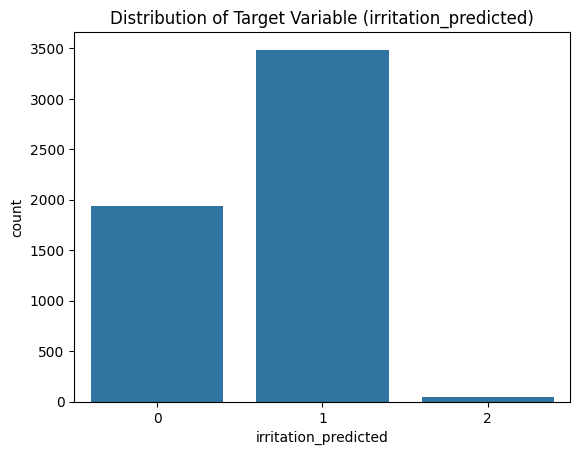

irritation_predicted
1    0.637644
0    0.353576
2    0.008780
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='irritation_predicted')
plt.title("Distribution of Target Variable (irritation_predicted)")
plt.show()

# Optional: exact values
print(df['irritation_predicted'].value_counts(normalize=True))


**Comedogenicity Distribution**


To understand how pore-clogging severity is distributed.

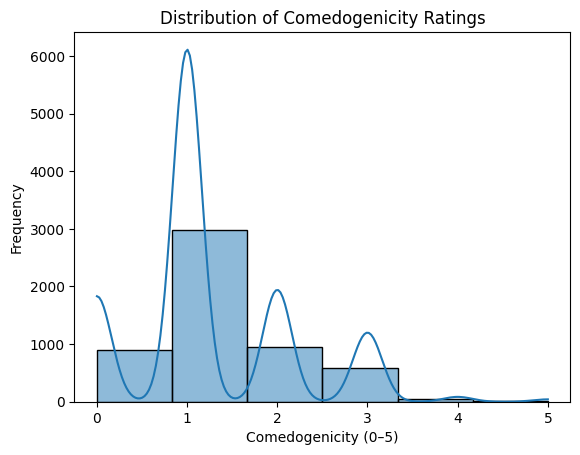

In [ ]:
sns.histplot(data=df, x='comedogenicity', bins=6, kde=True)
plt.title('Distribution of Comedogenicity Ratings')
plt.xlabel('Comedogenicity (0–5)')
plt.ylabel('Frequency')
plt.show()

**Occlusivity vs Irritation**

To explore whether ingredients with medium/high occlusivity have higher irritation rates under barriers.

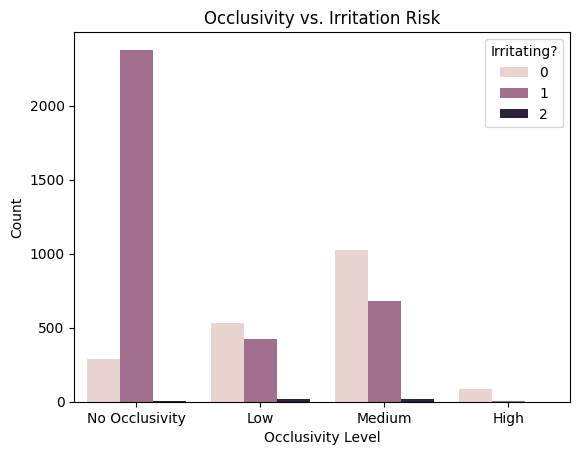

In [ ]:
sns.countplot(data=df, x='occlusivity', hue='irritation_predicted')
plt.title('Occlusivity vs. Irritation Risk')
plt.xlabel('Occlusivity Level')
plt.ylabel('Count')
plt.legend(title='Irritating?')
plt.show()

**Function Type vs Irritation**

Find which types of functions are more commonly irritating.

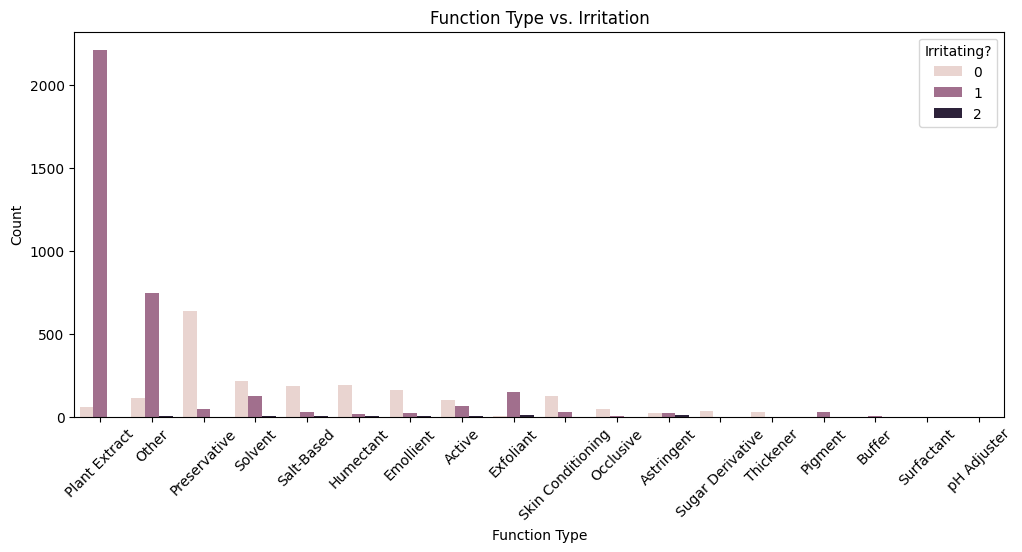

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='function_type', hue='irritation_predicted', order=df['function_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Function Type vs. Irritation')
plt.xlabel('Function Type')
plt.ylabel('Count')
plt.legend(title='Irritating?')
plt.show()


**Chemical Type vs Irritation**

Examine if chemical class has impact on irritation (e.g., acids vs esters).

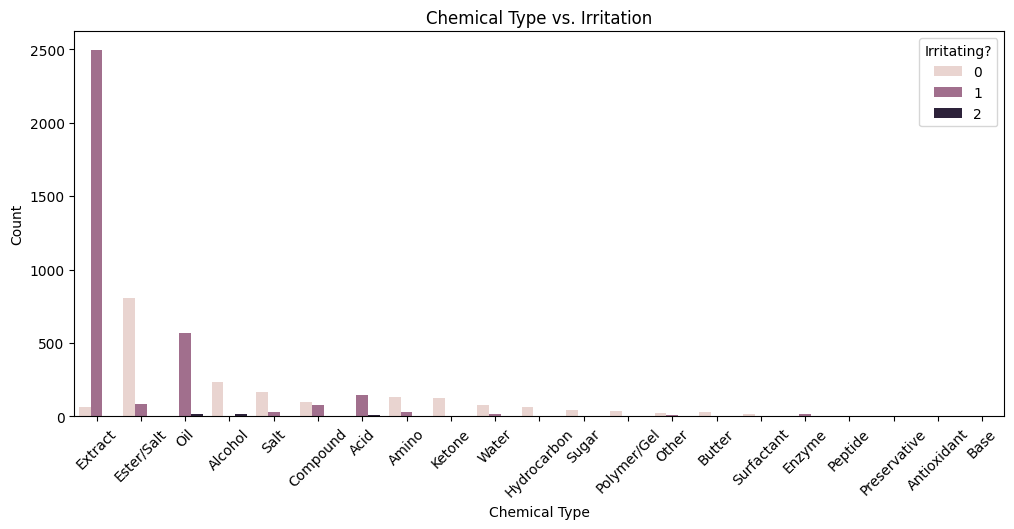

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='chemical_type', hue='irritation_predicted', order=df['chemical_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Chemical Type vs. Irritation')
plt.xlabel('Chemical Type')
plt.ylabel('Count')
plt.legend(title='Irritating?')
plt.show()


**Correlation Heatmap**

See how comedogenicity, occlusivity, penetration, barrier disruptor, and irritation relate.

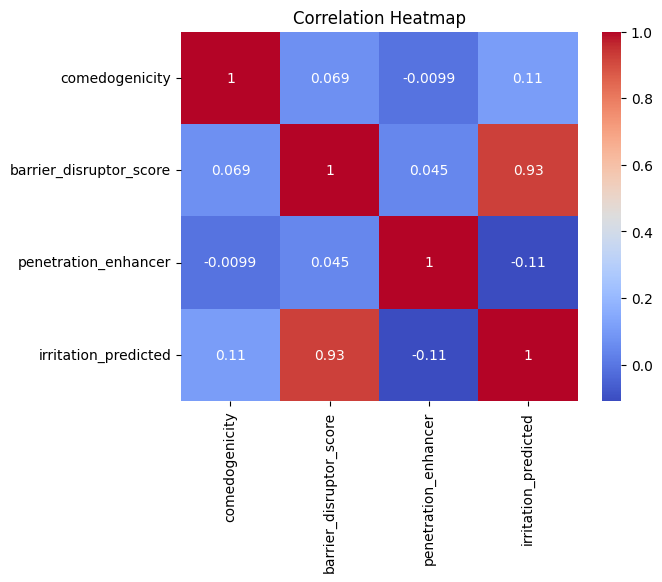

In [ ]:
corr = df[['comedogenicity', 'barrier_disruptor_score', 'penetration_enhancer', 'irritation_predicted']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Drop barrier_disruptor_score since it highly correlates with the irritation predicted

In [ ]:
df = df.drop(columns = 'barrier_disruptor_score')

KeyError: "['barrier_disruptor_score'] not found in axis"

In [ ]:
df.head()

,ingredient,comedogenicity,occlusivity,chemical_type,function_type,irritation_predicted,penetration_enhancer
0,water,0,3,20,13,0,False
1,glycolic acid,1,1,0,4,2,False
2,rosa damascena flower water,0,3,9,13,1,False
3,centaurea cyanus flower water,0,3,8,5,1,True
4,aloe barbadensis leaf water,0,3,9,13,1,False


Encode categorical Variables

 Manual Mapping for Ordinal Feature

In [ ]:
occl_map = {
    'No Occlusivity': 0,
    'Low': 1,
    'Moderate': 2,
    'High': 3
}
df['occlusivity_level'] = df['occlusivity'].map(occl_map)


One-Hot Encoding for Nominal Features

In [ ]:
df = pd.get_dummies(df, columns=['chemical_type', 'function_type'], drop_first=True)

Drop unneeded columns

In [ ]:
df = df.drop(columns = ['ingredient', 'occlusivity'])

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('irritation_predicted', axis=1)
y = df['irritation_predicted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       387
           1       1.00      0.99      1.00       697
           2       0.67      0.80      0.73        10

    accuracy                           0.99      1094
   macro avg       0.88      0.93      0.91      1094
weighted avg       0.99      0.99      0.99      1094

